# Overparameterization of deep ResNet: zero loss and mean-field analysis
## Ding, Chen, Li, Wright 2021

In [1]:
import matplotlib.pyplot as plt
import torch
from torchtyping import TensorType
from typing import Literal
import random

### Hyperparameters

In [23]:
D = 5
K = 2*D + 1
M = 10
MAX_LOG_L = 10
MAX_L = 2**MAX_LOG_L

In [3]:
device = torch.device("cuda")

### Parameters

In [77]:
def init_params(style: Literal["gaussian", "wiener", "zeros"]):
    global gaussian, wiener, theta, theta_untrained
    gaussian = torch.normal(0,1,size=(M,MAX_L,K), device=device)
    wiener = torch.cumsum(gaussian, axis=1)/MAX_L
    zeros = torch.zeros(M,MAX_L,K, device=device)
    if style == "gaussian":
        theta = gaussian
    elif style == "wiener":
        theta = wiener
    elif style == "zeros":
        theta = zeros
    theta.requires_grad = True
    theta_untrained = theta.clone().detach()
init_params("zeros")

### Before training

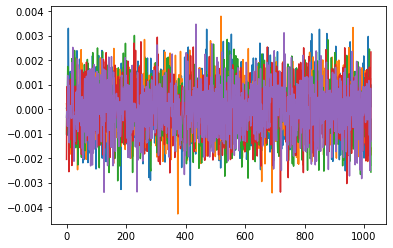

In [62]:
def plot_some_params(theta):
    plt.plot(theta[0,:,[0,1,2,3,4]].detach().cpu())
    plt.show()
plot_some_params(theta)

### Neural network modeled after (4)

#### Derivatives

In [63]:
def f(z: TensorType["b", "d"], theta: TensorType["k"]):
    W, U, b = theta[:D], theta[D:2*D], theta[2*D]
    return torch.einsum("d, b -> b d", U, torch.relu(torch.einsum("d, b d -> b", W, z) + b))

def F_slow(z: TensorType["b", "d"], t: int):
    return sum(f(z, theta[m, t]) for m in range(M))/M

In [64]:
def F_vectorized(z: TensorType["b", "d"], t: int):
    W, U, b = theta[:, t, :D], theta[:, t, D:2*D], theta[:, t, 2*D]
    return torch.einsum("m d, b m -> b d", U, torch.relu(torch.einsum("m d, b d -> b m", W, z) + b))

#### Forward pass

In [65]:
RESNET = True

In [66]:
def z_recursive(l: int, LOG_L: int, x: TensorType["b", "d"]):
    if l == 0:
        return x
    else:
        prev_z = z_recursive(l-1, L, x)
        if RESNET:
            return prev_z + F(prev_z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L
        else:
            return F(prev_z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L

In [67]:
def z_iterative(l: int, LOG_L: int, x: TensorType["b", "d"]):
    z = x
    for i in range(l):
        if RESNET:
            z = z + F_vectorized(z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L 
        else:
            z = F_vectorized(z, i*2**(MAX_LOG_L-LOG_L))/2**LOG_L 
    return z

In [68]:
def z(LOG_L: int, x: TensorType["b", "d"]):
    return z_iterative(2**LOG_L, LOG_L, x)

### Batch size and data

In [69]:
B = 100
x_generator = lambda: torch.normal(0,1,size=(B,D),device=device)
x = x_generator()

### Target functions

In [70]:
objectives = dict(
    y1 = lambda x: 1/(x+5),
    y2 = lambda x: x**3,
    y3 = lambda x: torch.sort(x, axis=1).values
)
OBJECTIVE = "y1"

### Training on Gaussian

In [71]:
STOCHASTIC = False
def train(lr=1000, iters=20):
    global theta, theta_trained
    for i in range(iters):
        theta.grad = None
        x_ = x if not STOCHASTIC else x_generator()
        y = z(MAX_LOG_L, x_)
        loss = torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x_))
        print(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr*theta.grad
    theta_trained = theta

In [78]:
init_params("gaussian")
train(lr=2000, iters=20)

1.100846529006958
0.02728576771914959
0.0029719821177423
0.0027005516458302736
0.0026769523974508047
0.0026608596090227365
0.0026473021134734154
0.0026352624408900738
0.002624153159558773
0.0026137609966099262
0.0026039420627057552
0.002594222780317068
0.002585165435448289
0.002577096689492464
0.0025694137439131737
0.002562066772952676
0.0025549952406436205
0.0025481090415269136
0.0025413986295461655
0.0025349098723381758


In [79]:
def plot_approximation_curve():
    Zs = [z(l,x) for l in range(MAX_LOG_L)]
    plt.plot([torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x)).item() for y in Zs])
    plt.show()
    plt.plot(range(4, len(Zs)), [torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x)).item() for y in Zs[4:]])
    plt.show()
    #plt.plot([[torch.linalg.norm(Zs[i][k]-Zs[i-1][k]).item() for k in range(B)] for i in range(1,len(Zs))])
    #plt.show()

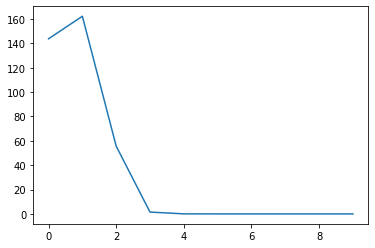

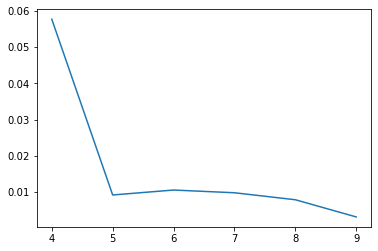

In [80]:
plot_approximation_curve()

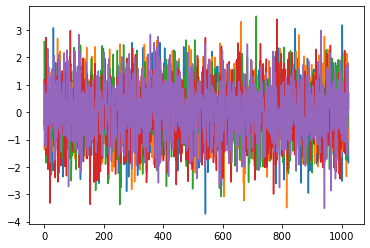

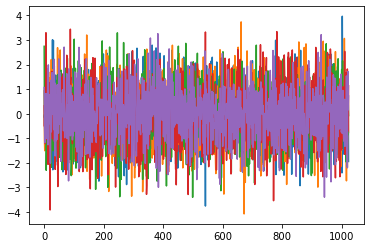

(None, None)

In [81]:
plot_some_params(theta_untrained), plot_some_params(theta_trained)

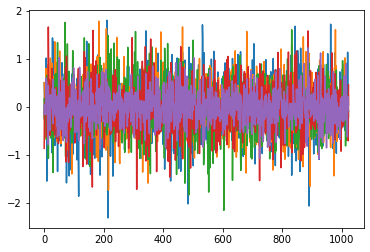

In [83]:
plot_some_params(theta_trained-theta_untrained)

### Training on continuous parameters

In [25]:
init_params("wiener")
train(lr=4000, iters=20)

1.1771724224090576
1.1666616201400757
1.1244678497314453
0.9424384236335754
0.5720667839050293
0.2841666042804718
0.1414920836687088
0.10861916840076447
0.15331268310546875
0.13447381556034088
0.04238715022802353
0.022161949425935745
0.016122598201036453
0.013451876118779182
0.011820470914244652
0.01065917033702135
0.009800952859222889
0.009163393639028072
0.00866668950766325
0.008255681954324245


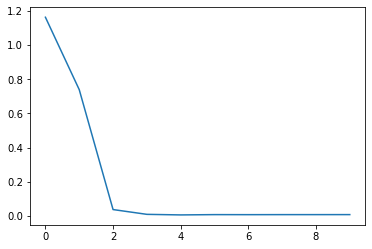

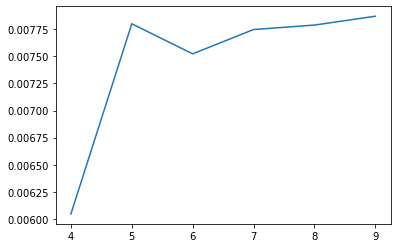

In [26]:
plot_approximation_curve()

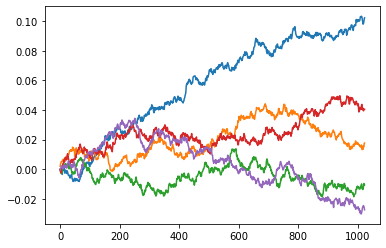

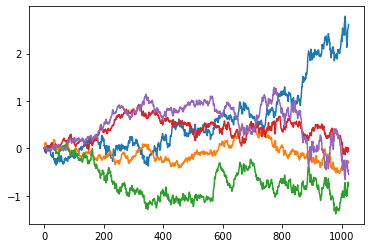

(None, None)

In [27]:
plot_some_params(theta_untrained), plot_some_params(theta_trained)

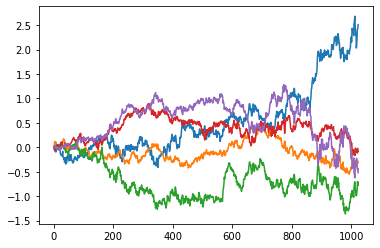

In [30]:
plot_some_params(theta_trained-theta_untrained)

### Do only the final layers matter?

In [512]:
theta = theta_trained

In [513]:
first_quarter = z_iterative(MAX_L//4, MAX_LOG_L, x)
second_quarter = z_iterative(MAX_L//2, MAX_LOG_L, x)
third_quarter = z_iterative(MAX_L//4*3, MAX_LOG_L, x)
final_output = z_iterative(MAX_L, MAX_LOG_L, x)

In [514]:
torch.trace(torch.cdist(x, first_quarter)).item()/B

0.3959264373779297

In [515]:
torch.trace(torch.cdist(first_quarter, second_quarter)).item()/B

0.6279476928710938

In [516]:
torch.trace(torch.cdist(second_quarter, third_quarter)).item()/B

0.6279176330566406

In [517]:
torch.trace(torch.cdist(third_quarter, final_output)).item()/B

0.6196324920654297

In [518]:
torch.trace(torch.cdist(x, final_output)).item()/B

1.7641925048828124

In [519]:
theta = theta_untrained

In [520]:
first_quarter = z_iterative(MAX_L//4, MAX_LOG_L, x)
second_quarter = z_iterative(MAX_L//2, MAX_LOG_L, x)
third_quarter = z_iterative(MAX_L//4*3, MAX_LOG_L, x)
final_output = z_iterative(MAX_L, MAX_LOG_L, x)

In [521]:
torch.trace(torch.cdist(x, first_quarter)).item()/B

0.00024619292467832567

In [522]:
torch.trace(torch.cdist(first_quarter, second_quarter)).item()/B

0.0003083883970975876

In [523]:
torch.trace(torch.cdist(third_quarter, final_output)).item()/B

0.0008961823582649231

In [524]:
torch.trace(torch.cdist(x, final_output)).item()/B

0.0018304204940795899

### Solve it using Runge-Kutta

In [525]:
def z_rk4(x: TensorType["b", "d"], log_dl: int = 1):
    z = x
    dl = 2**log_dl
    dt = dl/(2**MAX_LOG_L)
    for i in range(2**(MAX_LOG_L-log_dl)):
        t = i*dl
        k1 = F_vectorized(z, t)
        k2 = F_vectorized(z+k1*dt/2, t+dl//2)
        k3 = F_vectorized(z+k2*dt/2, t+dl//2)
        if t+dl < 2**MAX_LOG_L:
            k4 = F_vectorized(z+k3*dt, t+dl)
        else:
            k4 = F_vectorized(z+k3*dt, 2**MAX_LOG_L-1)
        z = z+dt/6*(k1+2*k2+2*k3+k4)
    return z

#### Approximation error

In [550]:
torch.nn.functional.mse_loss(z_rk4(x, log_dl=3), z(MAX_LOG_L,x)).item()

1.9560138231344837e-11

In [551]:
torch.nn.functional.mse_loss(z(MAX_LOG_L-1,x), z(MAX_LOG_L,x)).item()

2.0106784293094648e-11

#### Does it generalize?

In [528]:
x_ = x_generator()

In [544]:
torch.nn.functional.mse_loss(z_rk4(x_, log_dl=1), objectives[OBJECTIVE](x_)).item()

1.3120733499526978

In [545]:
torch.nn.functional.mse_loss(z(MAX_LOG_L,x_), objectives[OBJECTIVE](x_)).item()

1.3120750188827515

In [546]:
torch.nn.functional.mse_loss(z(MAX_LOG_L-1,x_), objectives[OBJECTIVE](x_)).item()

1.3120756149291992

In [532]:
%timeit z(MAX_LOG_L-1, x)

235 ms ± 690 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [533]:
%timeit z_rk4(x, log_dl=1)

1.08 s ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [534]:
%timeit z(MAX_LOG_L, x)

467 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Train through Runge-Kutta

In [535]:
STOCHASTIC = False
def train_rk4(lr: float =1000, iters: int =20, correction: bool = False):
    global theta, theta_trained
    for i in range(iters):
        theta.grad = None
        x_ = x if not STOCHASTIC else x_generator()
        y = z_rk4(x_, log_dl=1)
        loss = torch.nn.functional.mse_loss(y, objectives[OBJECTIVE](x_))
        print(loss.item())
        loss.backward()
        with torch.no_grad():
            if correction:
                theta[:,:-1:2,:] -= lr*theta.grad[:,:-1:2,:]
                theta[:,1:-1:2,:] -= lr*theta.grad[:,1:-1:2,:]*torch.norm(theta.grad[:,:-1:2,:])/torch.norm(theta.grad[:,1:-1:2,:])
                theta[:,-1,:] -= lr*theta.grad[:,-1,:]*torch.norm(theta.grad[:,-2,:])/torch.norm(theta.grad[:,-1,:])
            else:
                theta -= lr*theta.grad
    theta_trained = theta

In [536]:
init_params("wiener")
train_rk4(lr=2000, iters=10)

0.9985530972480774
0.9982379674911499
0.9978748559951782
0.9973936080932617
0.9967172741889954
0.9957278370857239
0.994249701499939
0.9920185208320618
0.9886378049850464
0.983522891998291


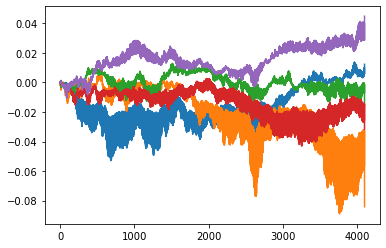

In [537]:
plot_some_params(theta_trained)

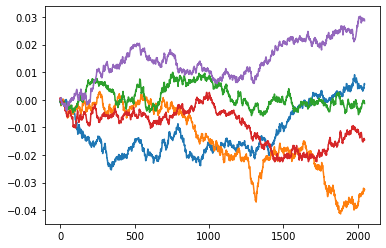

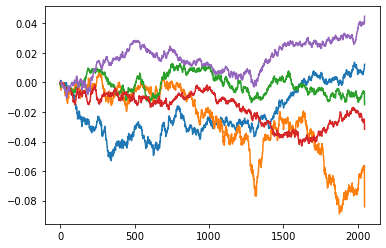

(None, None)

In [538]:
plot_some_params(theta_trained[:,::2,:]), plot_some_params(theta_trained[:,1::2,:])

In [539]:
torch.mean(theta_trained[:,::2,:]/theta_trained[:,1::2,:]).item()

0.46151217818260193

### Training with rescaled gradient

In [540]:
init_params("wiener")
train_rk4(lr=2000, iters=10, correction=True)

0.998684823513031
0.9985275864601135
0.9983706474304199
0.9982042908668518
0.9980222582817078
0.9978169798851013
0.9975766539573669
0.9972907304763794
0.996946394443512
0.9965268969535828


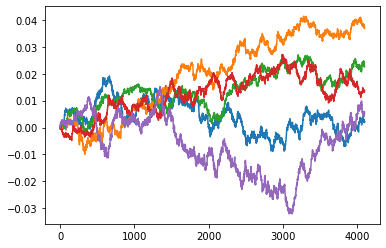

In [541]:
plot_some_params(theta_trained)